8/8 [==============================] - 0s 3ms/step
Epoch 1/100
Discriminator Loss: [0.3124534785747528, 0.5]
Generator Loss: 1.9103209972381592
1/1 [==============================] - 0s 333ms/step


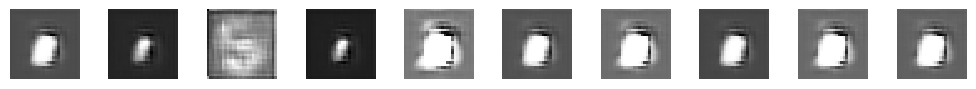

8/8 [==============================] - 0s 3ms/step
Epoch 11/100
Discriminator Loss: [0.2756003737449646, 0.5]
Generator Loss: 2.113741159439087
1/1 [==============================] - 0s 22ms/step


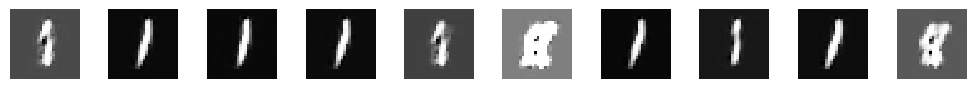

8/8 [==============================] - 0s 3ms/step
Epoch 21/100
Discriminator Loss: [0.24394387006759644, 0.5]
Generator Loss: 2.2837488651275635
1/1 [==============================] - 0s 19ms/step


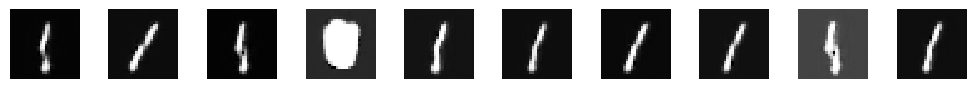

8/8 [==============================] - 0s 3ms/step
Epoch 31/100
Discriminator Loss: [0.27593427896499634, 0.5]
Generator Loss: 2.5557777881622314
1/1 [==============================] - 0s 32ms/step


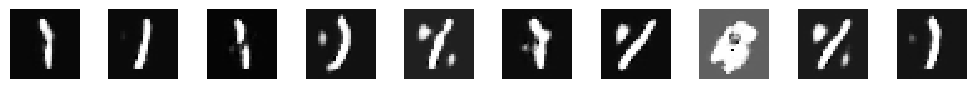

8/8 [==============================] - 0s 3ms/step
Epoch 41/100
Discriminator Loss: [0.4524446427822113, 0.453125]
Generator Loss: 1.6208159923553467
1/1 [==============================] - 0s 19ms/step


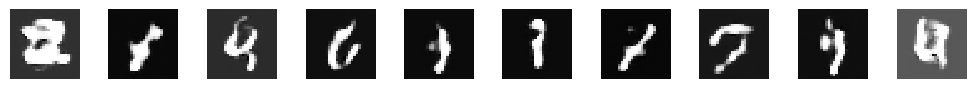

8/8 [==============================] - 0s 3ms/step
Epoch 51/100
Discriminator Loss: [0.44297683238983154, 0.435546875]
Generator Loss: 1.191199541091919
1/1 [==============================] - 0s 17ms/step


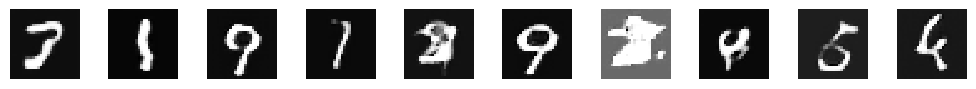

8/8 [==============================] - 0s 3ms/step
Epoch 61/100
Discriminator Loss: [0.423925518989563, 0.5]
Generator Loss: 2.105673313140869
1/1 [==============================] - 0s 20ms/step


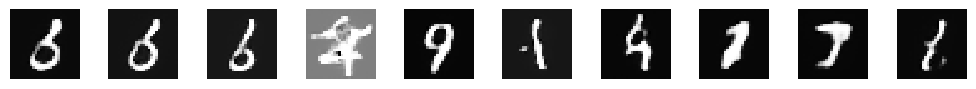

8/8 [==============================] - 0s 3ms/step
Epoch 71/100
Discriminator Loss: [0.5284518003463745, 0.37109375]
Generator Loss: 1.6646687984466553
1/1 [==============================] - 0s 23ms/step


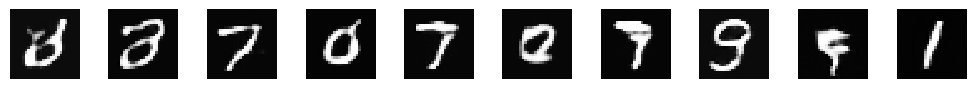

8/8 [==============================] - 0s 3ms/step
Epoch 81/100
Discriminator Loss: [0.478476345539093, 0.466796875]
Generator Loss: 1.6067421436309814
1/1 [==============================] - 0s 17ms/step


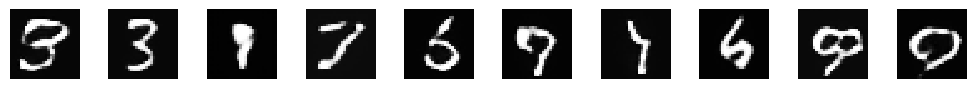

8/8 [==============================] - 0s 3ms/step
Epoch 91/100
Discriminator Loss: [0.5806203484535217, 0.45703125]
Generator Loss: 1.2420685291290283
1/1 [==============================] - 0s 23ms/step


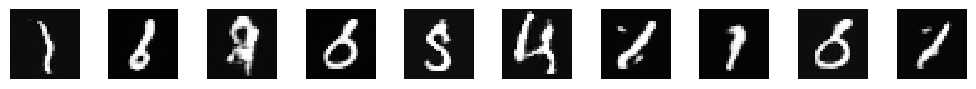

8/8 [==============================] - 0s 5ms/step


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0
x_train = np.expand_dims(x_train, axis=-1)

# Define the generator model
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=100))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(7 * 7 * 128, activation='relu'))
    model.add(layers.Reshape((7, 7, 128)))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128, kernel_size=3, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(64, kernel_size=3, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(1, kernel_size=3, padding='same', activation='tanh'))
    return model

# Define the discriminator model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Define the GAN model
gan_input = layers.Input(shape=(100,))
generated_image = generator(gan_input)
discriminator.trainable = False
gan_output = discriminator(generated_image)
gan = models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Training the GAN
def train_gan(epochs, batch_size=128, save_interval=10):
    batch_count = x_train.shape[0] // batch_size

    for e in range(epochs):
        for _ in range(batch_count):
            # Get a random set of real images
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            real_images = x_train[idx]

            # Generate fake images
            noise = np.random.normal(0, 1, (batch_size, 100))
            fake_images = generator.predict(noise)

            # Combine real and fake images
            x = np.concatenate([real_images, fake_images])

            # Labels for real and fake images
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 0.9

            # Train the discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(x, y_dis)

            # Train the generator
            noise = np.random.normal(0, 1, (batch_size, 100))
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y_gen)

        if e % save_interval == 0:
            print(f"Epoch {e+1}/{epochs}")
            print(f"Discriminator Loss: {d_loss}")
            print(f"Generator Loss: {g_loss}")
            plot_generated_images(e, generator)

def plot_generated_images(epoch, generator, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')
    plt.show()

# Train the GAN
train_gan(epochs=100, batch_size=256, save_interval=10)
